In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import pickle
import ast
import math 
import traceback
from sklearn import preprocessing
from ucimlrepo import fetch_ucirepo 

import seaborn as sns

2024-08-04 22:05:32.118070: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
dataset_name = "credit"

In [5]:
# fetch dataset 
credit_approval = fetch_ucirepo(id=27) 
  
# data (as pandas dataframes) 
X = credit_approval.data.features 
y = credit_approval.data.targets 
  
# metadata 
print(credit_approval.metadata) 
  
# variable information 
print(credit_approval.variables) 

{'uci_id': 27, 'name': 'Credit Approval', 'repository_url': 'https://archive.ics.uci.edu/dataset/27/credit+approval', 'data_url': 'https://archive.ics.uci.edu/static/public/27/data.csv', 'abstract': 'This data concerns credit card applications; good mix of attributes', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 690, 'num_features': 15, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['A16'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1987, 'last_updated': 'Wed Aug 23 2023', 'dataset_doi': '10.24432/C5FS30', 'creators': ['J. R. Quinlan'], 'intro_paper': None, 'additional_info': {'summary': 'This file concerns credit card applications.  All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data.\r\n  \r\nThis dataset is interesting because there is a good mix of attributes --

In [6]:
categorical_cols = ['A13', 'A12', 'A10', 'A9', 'A7', 'A6', 'A5', 'A4', 'A1']
# One-hot encode the categorical columns
df_encoded = pd.get_dummies(X, columns=categorical_cols)
# Initialize a scaler
scaler = preprocessing.StandardScaler()
# Fit and transform the data
X = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)
X = X.fillna(0)
# to numpy
X = X.values

In [7]:
y = np.array([1.0 if elem == "+" else 0.0 for elem in y["A16"]])

In [8]:
from sklearn import model_selection

In [9]:
X, Xtest, y, ytest = model_selection.train_test_split(X, y)

In [10]:
y.mean()

0.46421663442940037

In [11]:
ytest.sum()

67.0

## Specify learning algorithms

In [12]:
import math


def sigmoid(x):
    x = np.clip(x, -200, 200)
    y = 1 / (1 + np.exp(-x))
    return y


def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    #print(f"{X=}")
    #print(f"{theta.T=}")
    #print(f"{y=}")
    y = sigmoid(y)
    #print(f"{y=}")
    return y


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def cross_entropy(p, y, epsilon=1e-45):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    #print(f"{p=}")
    #print(f"{y=}")
    #print(f"{l=}")
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def log_ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
        log_y = np.log(y)
    else:
        log_y = u
    return log_y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    return newtheta

In [13]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

def train_model(
    X,
    y,
    Xtest,
    ytest,
    mode="rand",
    eta=0.01,
    lam=0,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # Used in polyak-becpi
    omega=1,
    # Added to enable non-adaptive stepsize experiments with pz != 1/2
    pz0 = 1/2,
    # For bec-minx1
    alpha = 1,
    x0 = 1,
    # multiplier to control sampling probability in bec-absloss
    prob_const = 1,
    # debug
    verbose=True,
    epsilon = 1e-45,
    max_iterations = 6500
):
    theta = np.zeros(X.shape[1])
    stheta = theta

    n_iterations = min(X.shape[0], max_iterations)  # Number of iterations
    #thetas = np.zeros((n_iterations, X.shape[1]))
    
    if verbose:
        print(f"Training with algorithm {mode}: {n_iterations} iterations with d={X.shape[1]}")
        
    losses = np.zeros(n_iterations)
    losses_reg = np.zeros(n_iterations)
    losses_test = np.zeros(n_iterations)
    losses_test_reg = np.zeros(n_iterations)
    accuracies = np.zeros(n_iterations)
    accuracies_test = np.zeros(n_iterations)
    labeled = np.zeros(n_iterations)
    #Delta = np.zeros(n_iterations)
    #sDelta = np.zeros(n_iterations)
    probs = np.zeros(n_iterations)
    #samples = []

    # for i in range(npoints):
    for i in range(n_iterations):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        if mode == "random":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "polyak_absloss":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=0, a_max=1)
            grad = zeta * grad / pz
        elif mode == "polyak_random":
            """
            Added to address the reviewer's comment:
            The authors conduct experiments on "uniform sampling" + "constant step size", "loss-based sampling" + "constant step size", 
            and "loss-based sampling" + "Polyak step size" to verify the effectiveness of the approach of loss-based sampling. For 
            completeness, it is necessary to present the performance of using "uniform sampling" + "Polyak step size" in the numerical experiments.
            """
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = pz0
            grad = zeta * grad / pz
        elif mode == "polyak_exponent": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            #zeta = kappa * (ratio(u) / (np.linalg.norm(xx) ** 2))
            zeta_log = math.log(kappa) + log_ratio(u) - math.log(np.linalg.norm(xx) ** 2)
            #zeta = math.exp(zeta_log)
            #zeta = min(zeta, kappa0)
            zeta = math.exp(min(zeta_log, math.log(kappa0)))
            pz = zeta ** polyakexp
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak_exponent_old": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "absloss":
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = 1 - np.exp(-bec)
            pz = omega * pz
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = backward(xx, yy, p)
        elif mode == "minx1":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([(bec / x0) ** alpha, 1])
            grad = backward(xx, yy, p)
        elif mode == "polyak-minx1":
            # Binary cross-entropy loss with Polyak adaptive step size
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            grad = backward(xx, yy, p)
            
            # Compute pz as in bec-minx1 mode
            pz = np.min([(bec / x0) ** alpha, 1])

            # Compute u and zeta as in polyak-bec mode
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            
            # Compute the gradient of the binary cross-entropy loss with respect to theta
            dL_dpz = -(y / pz - (1 - y) / (1 - pz))
            dL_dbec = 0 if (bec / x0) > 1 else alpha * ((bec / x0) ** (alpha - 1)) / x0

            # Apply the Polyak adaptive step size to the gradient
            scaling_factor = zeta ** (1 - polyakexp)
            grad = scaling_factor * grad

        # sampling
        pz = np.clip(pz, epsilon, 1-epsilon)
        z = np.random.binomial(1, pz)
        #print(f"{p=}")
        #print(f"{yy=}")
        losses[i] = loss(p, yy)
        losses_reg[i] = losses[i] + lam * np.linalg.norm(theta)
        
        #stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta
        accuracies[i] = accuracy(p, yy)

        labeled[i] = z
        probs[i] = pz
        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            #samples.append(i)

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        p = forward(Xtest, theta)
        #print(f"{p=}")
        #print(f"{ytest=}")
        losses_test[i] = loss(p, ytest)
        losses_test_reg[i] = losses_test[i] + lam * np.linalg.norm(theta)
        accuracies_test[i] = accuracy(p, ytest)
        
        """
        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)
        """
        
        #p = forward(Xtest, theta)

        """
        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)
        """

        if verbose and i % 10 == 0:
            print(f"loss: {losses_test[i]}, train loss: {losses[i]}, ||theta||_1: {np.sum(np.abs(theta))} acc: {accuracies[i]}")

    return {
        "losses": losses.tolist(),
        "losses_reg": losses_reg.tolist(),
        "losses_test": losses_test.tolist(),
        "losses_test_reg": losses_test_reg.tolist(),
        "labeled": labeled.tolist(),
        "theta": theta.tolist(),
        #"stheta": stheta,
        "probs": probs.tolist(),
        "accuracies": accuracies.tolist(),
        "accuracies_test": accuracies_test.tolist(),
        #"samples": samples.tolist(),
        #"thetas": thetas.tolist(),
    }

## Use best hyperparams to construct plot
We have stored results from our hyperparameter tuning run. Here we load the results file, and will use the best hyperparameters per method.

In [14]:
hyperparam_results = pd.read_csv("hyperparams_train_loss_zero_init_noreg_target050_eta300.csv", delimiter="\t", header=None)
hyperparam_results.columns = ["algorithm", "loss", "hyperparams"]

In [15]:
# Calculate best hyperparameters per method
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [16]:
hyperparam_per_algo["absloss"] = {"eta": 0.1}
hyperparam_per_algo["random"] = {"eta": 0.1}
hyperparam_per_algo["polyak_absloss"] |= {
    "eta": 0.1,
    "kappa": 10,
    "kappa0": 0.99,
    "omega": 1.1
}
hyperparam_per_algo["polyak_exponent"] |= {
    "eta": 0.1,
    "kappa": 10,
    "kappa0": 0.99,
    "omega": 1.1
}

In [17]:
hyperparam_per_algo

{'polyak_absloss': {'kappa': 10, 'kappa0': 0.99, 'eta': 0.1, 'omega': 1.1},
 'polyak_exponent': {'kappa': 10,
  'kappa0': 0.99,
  'eta': 0.1,
  'polyakexp': 0.9951814804061615,
  'omega': 1.1},
 'absloss': {'eta': 0.1},
 'random': {'eta': 0.1}}

# Plot 0: train loss of rand vs absloss (first run for absloss, then run for rand for matching pz)

- mean train loss curve
- mean test loss curve
- accuracy

In [18]:
absloss_params = hyperparam_per_algo["absloss"]

results_absloss = train_model(
    X, y, Xtest, ytest, mode="absloss", **absloss_params
)

Training with algorithm absloss: 517 iterations with d=46
loss: 0.6931471805599454, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.6548038984615434, train loss: 0.7853574171404698, ||theta||_1: 1.920541460721368 acc: 0.0
loss: 0.5366308554769108, train loss: 0.18342390835050865, ||theta||_1: 5.367371304690111 acc: 1.0
loss: 0.44559798074187823, train loss: 0.08621373016405615, ||theta||_1: 5.575123000840751 acc: 1.0
loss: 0.4350283126663071, train loss: 0.38914757611696155, ||theta||_1: 6.5680433118132475 acc: 1.0
loss: 0.4981740826613892, train loss: 0.11713505626137721, ||theta||_1: 10.81693081772852 acc: 1.0
loss: 0.49100141579314954, train loss: 0.17631109129174047, ||theta||_1: 12.325819327450551 acc: 1.0
loss: 0.5586778641518302, train loss: 0.03389783725547736, ||theta||_1: 12.680660359839235 acc: 1.0
loss: 0.6901595748074096, train loss: 0.19590717913685676, ||theta||_1: 13.099873466788909 acc: 1.0
loss: 0.5436268273395763, train loss: 0.05127630114168117, ||

In [19]:
absloss_mean_sampling_prob = np.mean(results_absloss["probs"])

In [20]:
absloss_mean_sampling_prob

0.2724329622002572

In [21]:
rand_params = hyperparam_per_algo["random"]

results_rand = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(rand_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 517 iterations with d=46
loss: 0.6931471805599454, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.5337427131783727, train loss: 0.41233561763357296, ||theta||_1: 2.829902810529279 acc: 1.0
loss: 0.5108089096383005, train loss: 0.11224938533704638, ||theta||_1: 3.9539916765553937 acc: 1.0
loss: 0.48351306577278286, train loss: 0.05603380502307679, ||theta||_1: 4.77737398514473 acc: 1.0
loss: 0.4633467141469362, train loss: 0.1618606459923393, ||theta||_1: 4.903114037662618 acc: 1.0
loss: 0.5076339744030622, train loss: 0.1585973160997294, ||theta||_1: 8.94751379473376 acc: 1.0
loss: 0.47315478783546416, train loss: 0.12816903531044688, ||theta||_1: 9.123270481249698 acc: 1.0
loss: 0.5255649984616256, train loss: 0.2508679957094799, ||theta||_1: 9.86153036326443 acc: 1.0
loss: 0.49925354093571844, train loss: 0.3861021678624432, ||theta||_1: 9.896257404567482 acc: 1.0
loss: 0.5174381408884761, train loss: 0.14655759711768743, ||theta||_1

In [22]:
results_rand_absloss_params = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(absloss_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 517 iterations with d=46
loss: 0.6931471805599454, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.6001335198907171, train loss: 0.6277991018639579, ||theta||_1: 1.8151967187642508 acc: 1.0
loss: 0.6044865165443744, train loss: 0.7909579415199222, ||theta||_1: 2.98616305174355 acc: 0.0
loss: 0.5756697807073213, train loss: 0.3775363444180701, ||theta||_1: 3.2909276749364 acc: 1.0
loss: 0.5652097327865714, train loss: 0.18370896078178894, ||theta||_1: 3.6719654433611737 acc: 1.0
loss: 0.5120347013227982, train loss: 0.6418725579574317, ||theta||_1: 3.9885179965188984 acc: 1.0
loss: 0.49760362187319335, train loss: 0.27145829443178754, ||theta||_1: 4.249823301144636 acc: 1.0
loss: 0.47868273896426966, train loss: 0.36541343217036704, ||theta||_1: 4.584369826046728 acc: 1.0
loss: 0.4773138715694324, train loss: 0.3393548251312637, ||theta||_1: 5.085112925335048 acc: 1.0
loss: 0.46653468784351093, train loss: 0.16531776677864862, ||theta||_

In [23]:
results_absloss_rand_params = train_model(
    X, y, Xtest, ytest, mode="absloss", verbose=True, **rand_params
)

Training with algorithm absloss: 517 iterations with d=46
loss: 0.6103615537795333, train loss: 0.6931471805599453, ||theta||_1: 1.2734486677530916 acc: 0.5
loss: 0.5068782977046573, train loss: 0.5916823984662956, ||theta||_1: 2.24330927594848 acc: 1.0
loss: 0.5352547287330558, train loss: 0.1328014846833519, ||theta||_1: 3.9088136232600306 acc: 1.0
loss: 0.4944054931992578, train loss: 0.05209715815091275, ||theta||_1: 4.418583253880567 acc: 1.0
loss: 0.4526650969450149, train loss: 0.2710412566758461, ||theta||_1: 4.925806428656055 acc: 1.0
loss: 0.4697447955426332, train loss: 0.14627676726377153, ||theta||_1: 9.099078948479068 acc: 1.0
loss: 0.45762015463065897, train loss: 0.31322198721372735, ||theta||_1: 9.540688831944001 acc: 1.0
loss: 0.5086154795650324, train loss: 0.2367549111293316, ||theta||_1: 9.66162874425087 acc: 1.0
loss: 0.6359810415594188, train loss: 0.3499594256976668, ||theta||_1: 10.408461337898348 acc: 1.0
loss: 0.6093251073821103, train loss: 0.033069724618494

In [24]:
def results_to_df(results):
    dfs = []
    for k, v in results.items():
        df = pd.DataFrame(
            {
                "train_loss": v["losses"],
                "train_loss_reg": v["losses_reg"],
                "test_loss": v["losses_test"],
                "test_loss_reg": v["losses_test_reg"],
                "iteration": range(1, len(v["losses"]) + 1),
                "labeled": v["labeled"],
                "probs": v["probs"],
                "train_accuracy": v["accuracies"],
                "test_accuracy": v["accuracies_test"],
            }
        )
        df["method"] = k
        df["mean_train_loss"] = np.cumsum(df.train_loss) / df.iteration
        df["mean_test_loss"] = np.cumsum(df.test_loss) / df.iteration
        df["mean_test_accuracy"] = np.cumsum(df.test_accuracy) / df.iteration
        df["mean_train_accuracy"] = np.cumsum(df.train_accuracy) / df.iteration
        df["cost"] = np.cumsum(df.labeled)
        dfs += [df]   
    
    return pd.concat(dfs, axis=0)

results_df = results_to_df(
    {
        "absloss": results_absloss,
        "random": results_rand,
        "random_with_absloss_params": results_rand_absloss_params,
        "absloss_with_random_params": results_absloss_rand_params,
    }
)

(0.0, 1000.0)

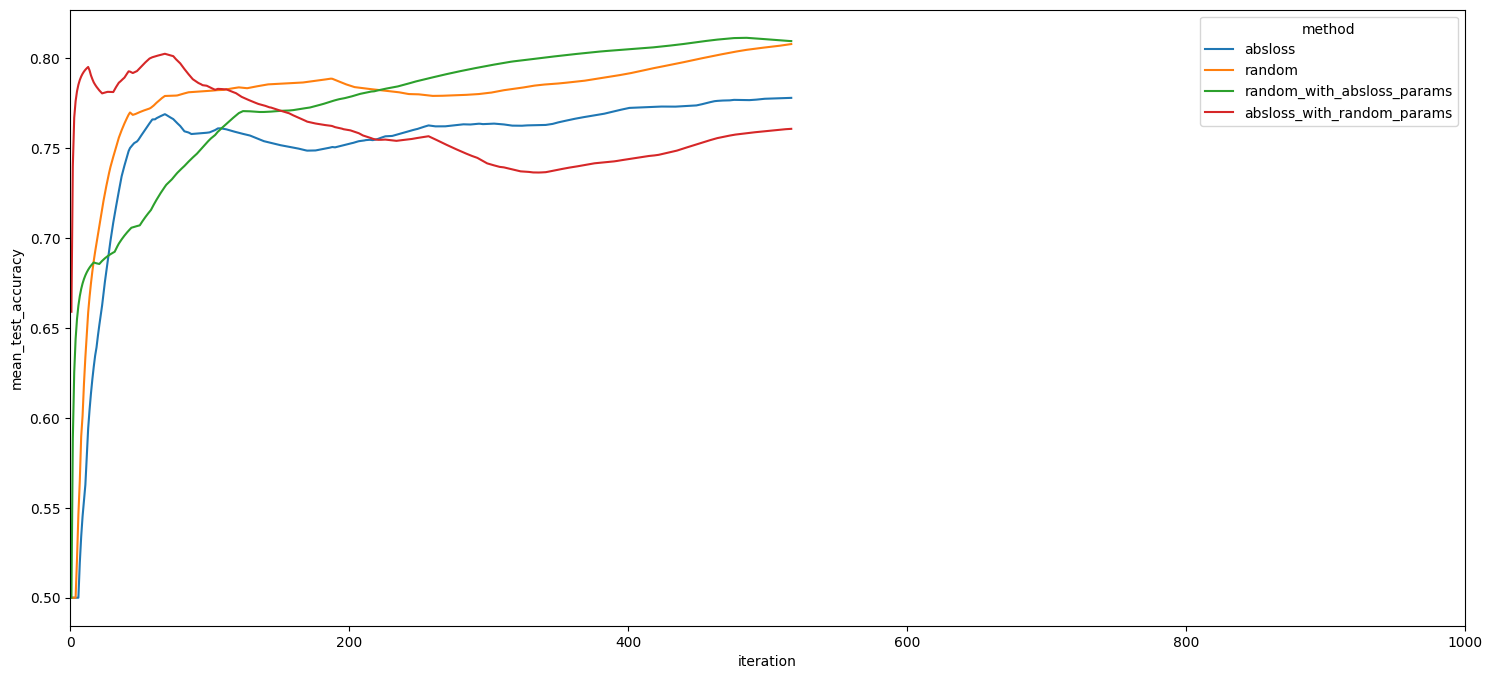

In [25]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    data=results_df,#results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_accuracy",
    hue="method"
)

ax.set_xlim((0, 1000))

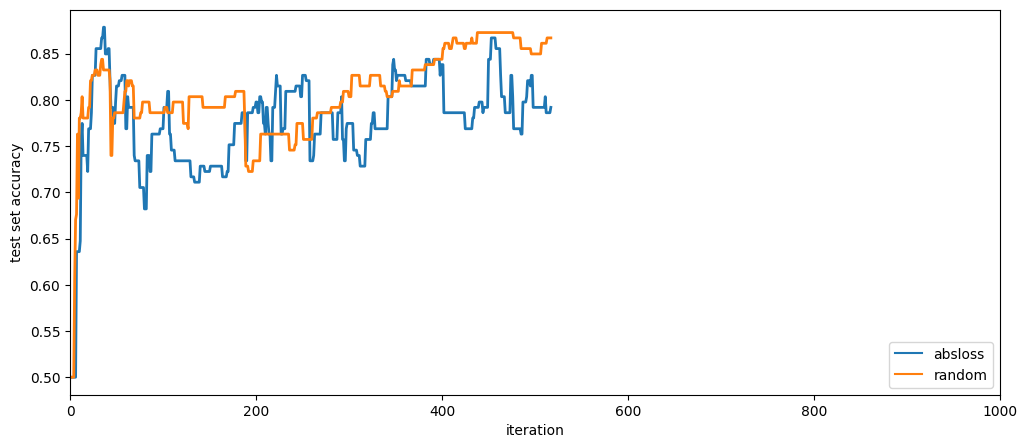

In [26]:
plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="test_accuracy",
    hue="method",
    linewidth=2
)

legend = ax.get_legend()
legend.set_title('')

ax.set(ylabel="test set accuracy")
sns.move_legend(ax, "lower right")

ax.set_xlim((0, 1000))

plt.savefig(f"figure_8a_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

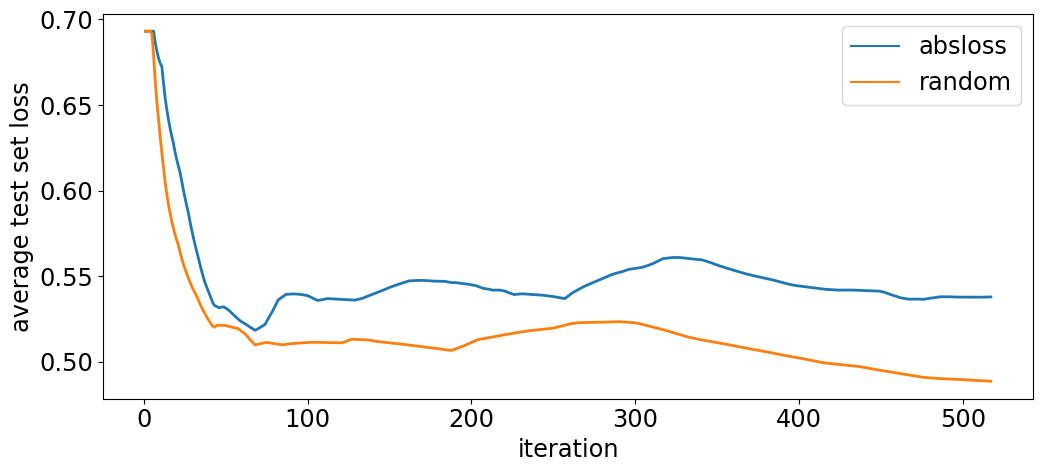

In [27]:
plt.figure(figsize=(12,5))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_loss",
    hue="method",
    linewidth=2
)
ax.set(ylabel="average test set loss")
legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_7a_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

Text(0, 0.5, 'average cross entropy loss')

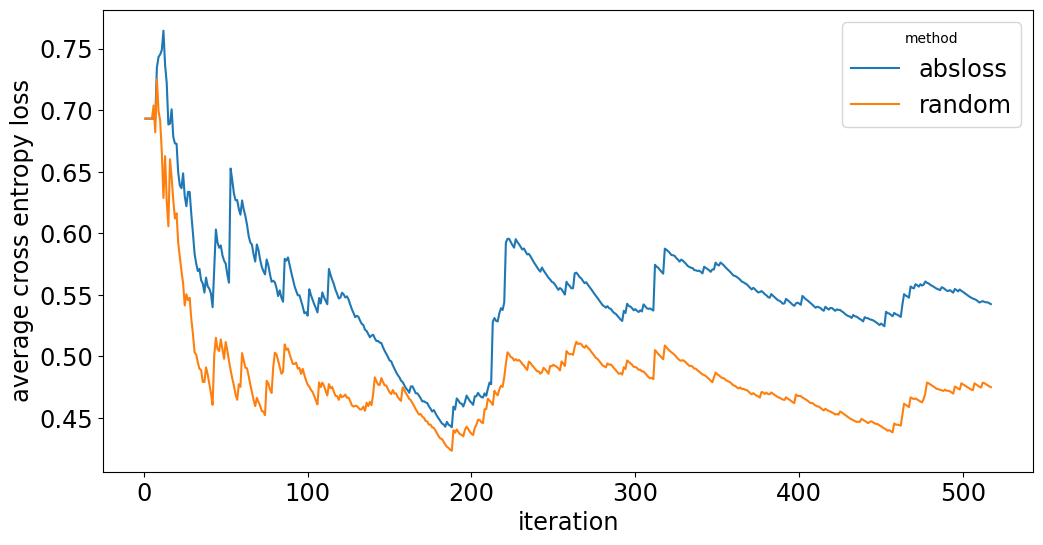

In [28]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

#plt.xscale('log')
#plt.yscale('log')

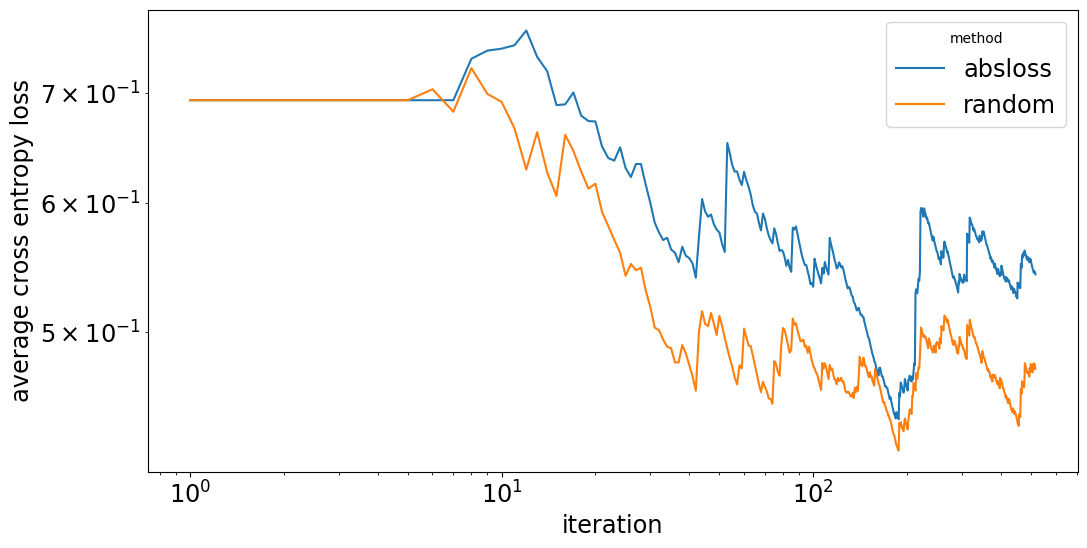

In [29]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

plt.xscale('log')
plt.yscale('log')

# Plot 1: train loss of rand vs Polyak exponent 
First run for various Polyak exponent values, and the run for rand for matching pz

- mean train loss curve
- mean test loss curve
- accuracy

For a single instance, polyak exponent method does:

pz = zeta ** polyakexponent

We aim to control the mean of pz across the dataset. 
we can find approximate solutions by taking zeta to be constant.

mean_pz = c ** polyakexponent

We don't know what c is because it depends on kappa, kappa0, 
and the losses in complex ways. However,  Then we can run the training loop
with polyakexp = 1 and take the empirical mean of the pz values to find our estimate for c.

Now we can find estimates of the polyakexp values that will lead to any desired mean_pz a using:

a = c ** polyakexp
log(a) = log(c ** ployakexp)
log(a) = ployakexp * log(c)
polyakexp = log(a) / log(c)

In practice, c is not a constant, but we instead have an instance-specific zeta.
As a result, it is likely that when we use this to derive this equation that gives us a value of polyakexp
for a desired sampling probability a, that the empirical mean sampling probability somewhat deviates that.

This is OK, since we're not looking to control pz precisely. Rather, we are looking to verify that polyak exponent
is more efficient than random sampling even in scenarios where we sample. We are simply looking to cover a wide range
of sampling probabilities.

To achieve a fair comparison against random sampling, we will calculate the empirical pz of the polyak exponent runs under a
and then run a random sampling under the same probability.

In [30]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyakexp_1_results = train_model(
    X, y, Xtest, ytest, mode="polyak_exponent", **(polyak_exponent_params | {"polyakexp": 1})
)

c = np.mean(polyakexp_1_results["probs"])

Training with algorithm polyak_exponent: 517 iterations with d=46
loss: 0.6103615537795333, train loss: 0.6931471805599453, ||theta||_1: 1.2734486677530916 acc: 0.5
loss: 0.45648729072191474, train loss: 0.3793216339443873, ||theta||_1: 3.6051736936608685 acc: 1.0
loss: 0.446052825006941, train loss: 0.09162711666385387, ||theta||_1: 4.867248627793179 acc: 1.0
loss: 0.4011036463419337, train loss: 0.01875483380979794, ||theta||_1: 5.335899716797595 acc: 1.0
loss: 0.3860217840378158, train loss: 0.14699436020050743, ||theta||_1: 6.30897637042831 acc: 1.0
loss: 0.38770161487057, train loss: 0.04103439298140313, ||theta||_1: 9.877294316992016 acc: 1.0
loss: 0.4043227614151479, train loss: 0.17265011768593855, ||theta||_1: 10.791604529353657 acc: 1.0
loss: 0.39354114028608816, train loss: 0.006658316314272798, ||theta||_1: 10.922721062262106 acc: 1.0
loss: 0.41834712889726533, train loss: 0.004605167495865511, ||theta||_1: 11.928757900150673 acc: 1.0
loss: 0.37178932464891973, train loss: 

In [31]:
# We're aiming to achieve sampling probabilities <0.1, 0.2, ..., 1.0>
#target_pzs = [0.1 * i for i in range(1, 11)]
target_pzs = [0.01, 0.1, 0.25, 0.5]
polyak_exps = [math.log(a) / math.log(c) for a in target_pzs]
polyak_exps

[73.87273575082622, 36.93636787541311, 22.23790932275765, 11.118954661378824]

In [32]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyak_exponent_results = {
    f"polyak_exponent_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="polyak_exponent", verbose=False, **(polyak_exponent_params | {"polyakexp": polyak_exp})
    )
    for polyak_exp in polyak_exps
}

In practice, c is not a constant, but we instead have an instance-specific zeta that depends on kappa, kappa0, and the losses in complex ways.
As a result, it is likely that the empirical mean sampling probabilities somewhat deviate from our targets target_pzs.

We now calculate the empirical pzs of these polyak exponent runs.

In [33]:
empirical_pzs = []
for key in polyak_exponent_results.keys():
    empirical_pzs += [np.mean(polyak_exponent_results[key]["probs"])]

In [34]:
empirical_pzs

[0.38860587305379374,
 0.5690824703274531,
 0.6889058695429708,
 0.8336545964675897]

In [35]:
rand_params = hyperparam_per_algo["random"]

rand_results = {
    f"random_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="random", verbose=False, **(rand_params | {"pz0": empirical_pz})
    )
    for polyak_exp, empirical_pz in zip(polyak_exps, empirical_pzs)
}

In [36]:
plot1_df = results_to_df((rand_results | polyak_exponent_results))
plot1_df[['method', 'polyak_exp']] = plot1_df['method'].str.rsplit('_', n=1, expand=True)

In [37]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).train_loss.mean()

method           polyak_exp  probs       
polyak_exponent  11.1        4.773693e-12    0.073131
                             4.255551e-11    0.259805
                             1.438840e-10    1.596017
                             4.140622e-09    2.129216
                             1.339660e-08    3.488404
                                               ...   
                 73.9        4.759484e-01    0.357720
random           11.1        8.336546e-01    0.471816
                 22.2        6.889059e-01    0.430748
                 36.9        5.690825e-01    0.467557
                 73.9        3.886059e-01    0.453812
Name: train_loss, Length: 300, dtype: float64

In [38]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).mean_train_loss.min()

method           polyak_exp  probs       
polyak_exponent  11.1        4.773693e-12    3.151374
                             4.255551e-11    0.507341
                             1.438840e-10    2.267828
                             4.140622e-09    4.010209
                             1.339660e-08    3.581227
                                               ...   
                 73.9        4.759484e-01    0.387171
random           11.1        8.336546e-01    0.371827
                 22.2        6.889059e-01    0.385244
                 36.9        5.690825e-01    0.386739
                 73.9        3.886059e-01    0.411891
Name: mean_train_loss, Length: 300, dtype: float64

Polyak exp value 73.9 has rows (1034, 16)
Polyak exp value 36.9 has rows (1034, 16)
Polyak exp value 22.2 has rows (1034, 16)
Polyak exp value 11.1 has rows (1034, 16)


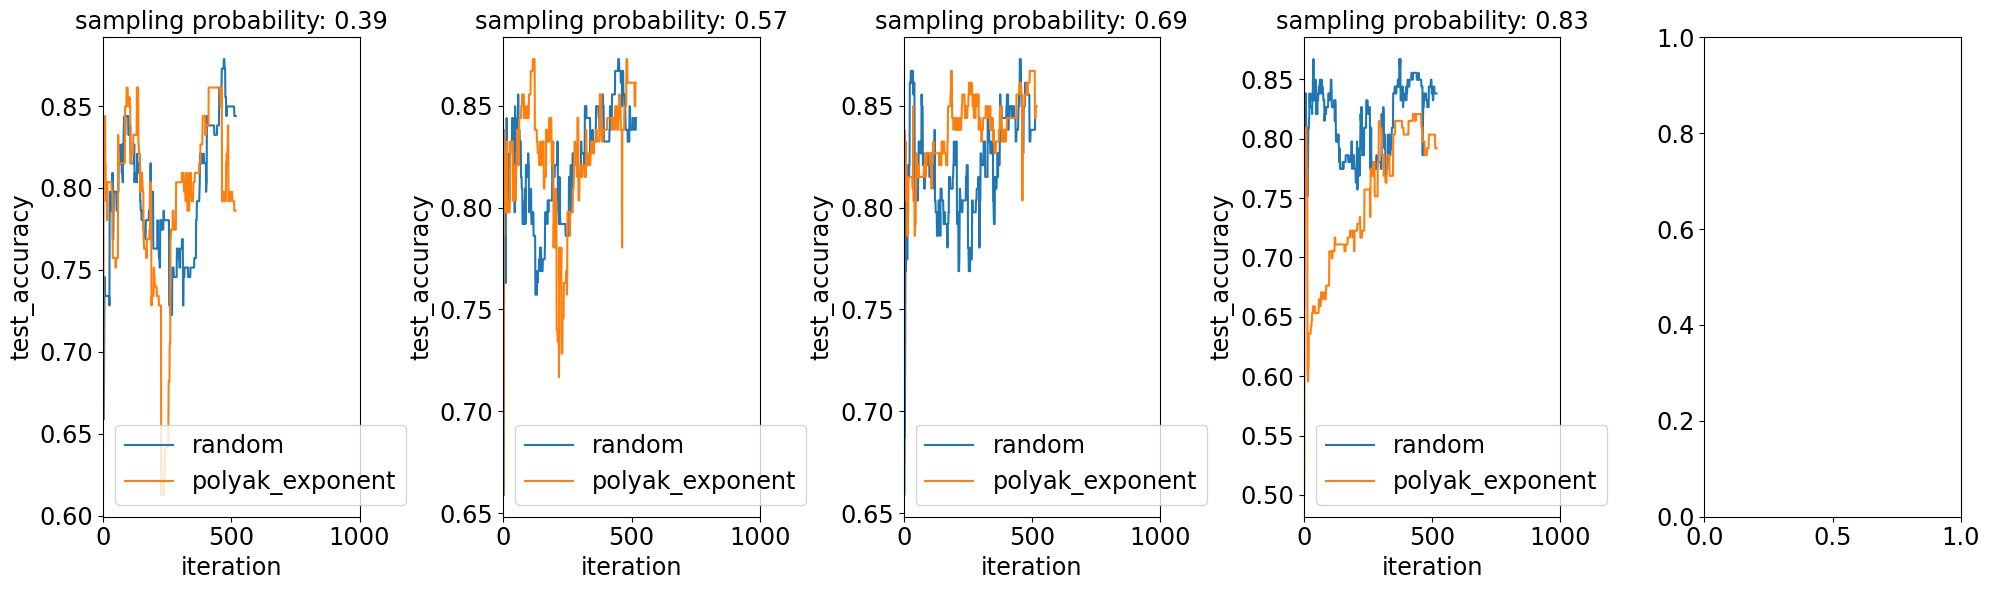

In [39]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]#[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    ax.set_xlim((0, 1000))
    
    i+=1
f.tight_layout()

Polyak exp value 73.9 has rows (1034, 16)
Polyak exp value 36.9 has rows (1034, 16)
Polyak exp value 22.2 has rows (1034, 16)
Polyak exp value 11.1 has rows (1034, 16)


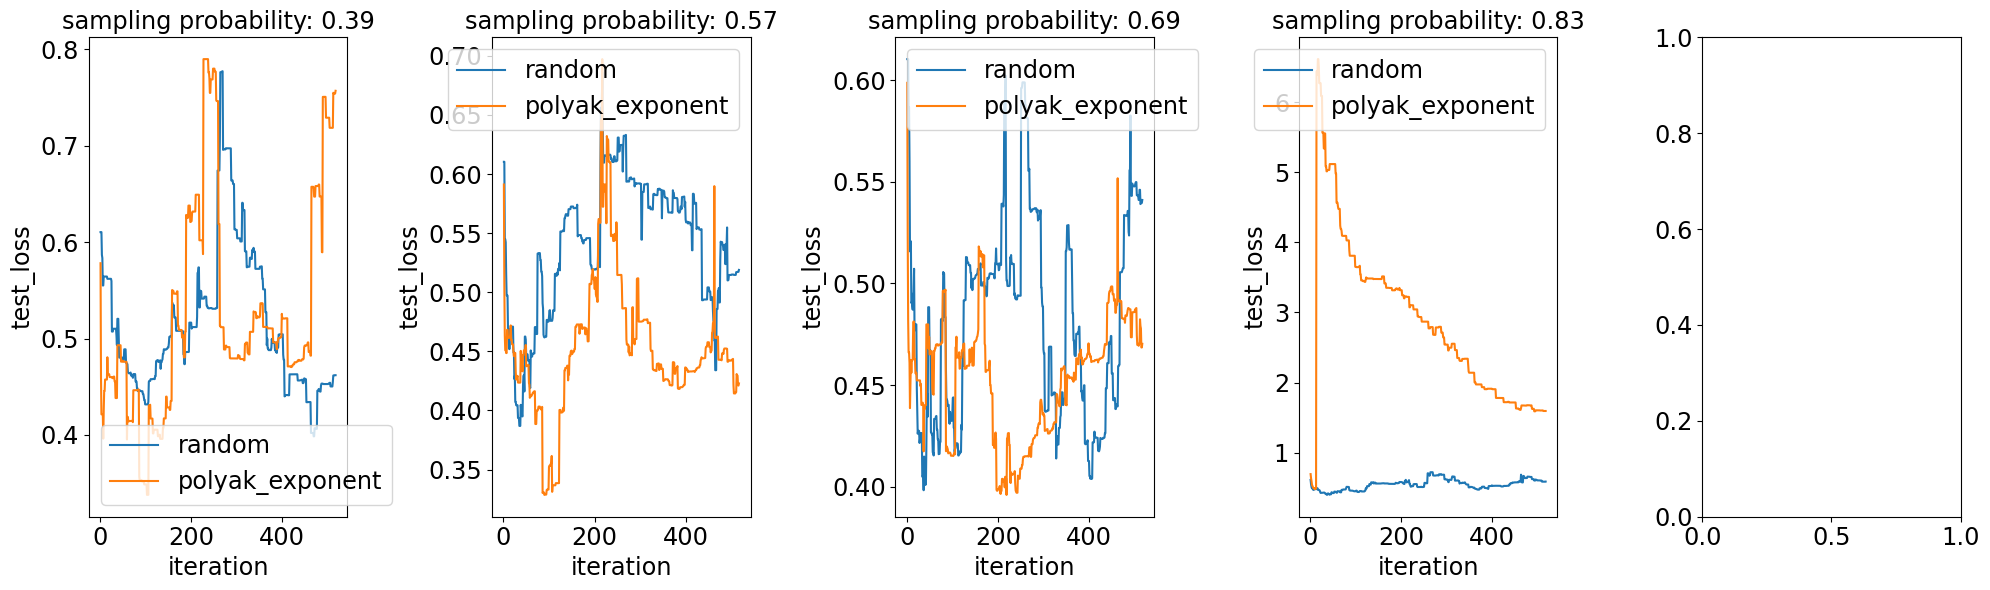

In [40]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    #ax.set_ylim((0.63, 0.7))
    
    i+=1
f.tight_layout()

In [41]:
plot1_df["method"] = [method if method != "polyak_exponent" else "polyak_power_function" for method in plot1_df.method]

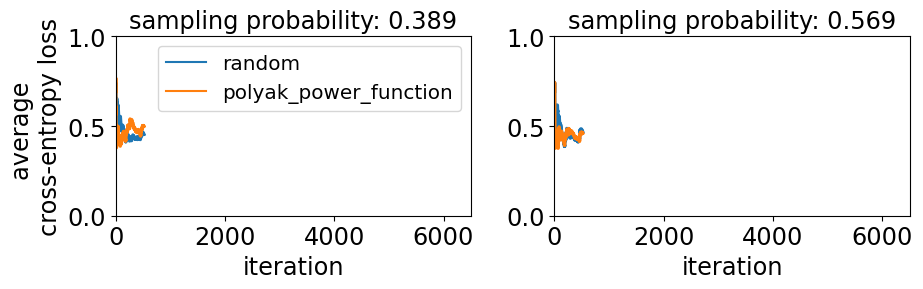

In [42]:
f, axs = plt.subplots(1, 2, figsize=(9.5, 3.0))
i = 0
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

for polyak_exp, pz in zip(polyak_exps[:2], empirical_pzs[:2]):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax,
        linewidth=2.5
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.00, 1))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[0].set_ylabel("average \ncross-entropy loss")
axs[1].set_ylabel("")

axs[1].get_legend().remove()

f.tight_layout()

plt.savefig(f"figure_2_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

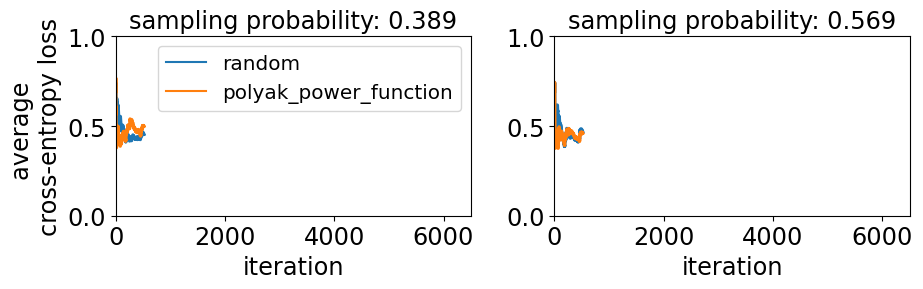

In [43]:
f, axs = plt.subplots(1, 2, figsize=(9.5, 3.0))
i = 0
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

for polyak_exp, pz in zip(polyak_exps[:2], empirical_pzs[:2]):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax,
        linewidth=2.5
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.00, 1))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[0].set_ylabel("average \ncross-entropy loss")
axs[1].set_ylabel("")

axs[1].get_legend().remove()

f.tight_layout()

plt.savefig(f"figure_2_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

0.38860587305379374
Polyak exp value 73.9 has rows (1034, 16)
0.5690824703274531
Polyak exp value 36.9 has rows (1034, 16)
0.6889058695429708
Polyak exp value 22.2 has rows (1034, 16)
0.8336545964675897
Polyak exp value 11.1 has rows (1034, 16)


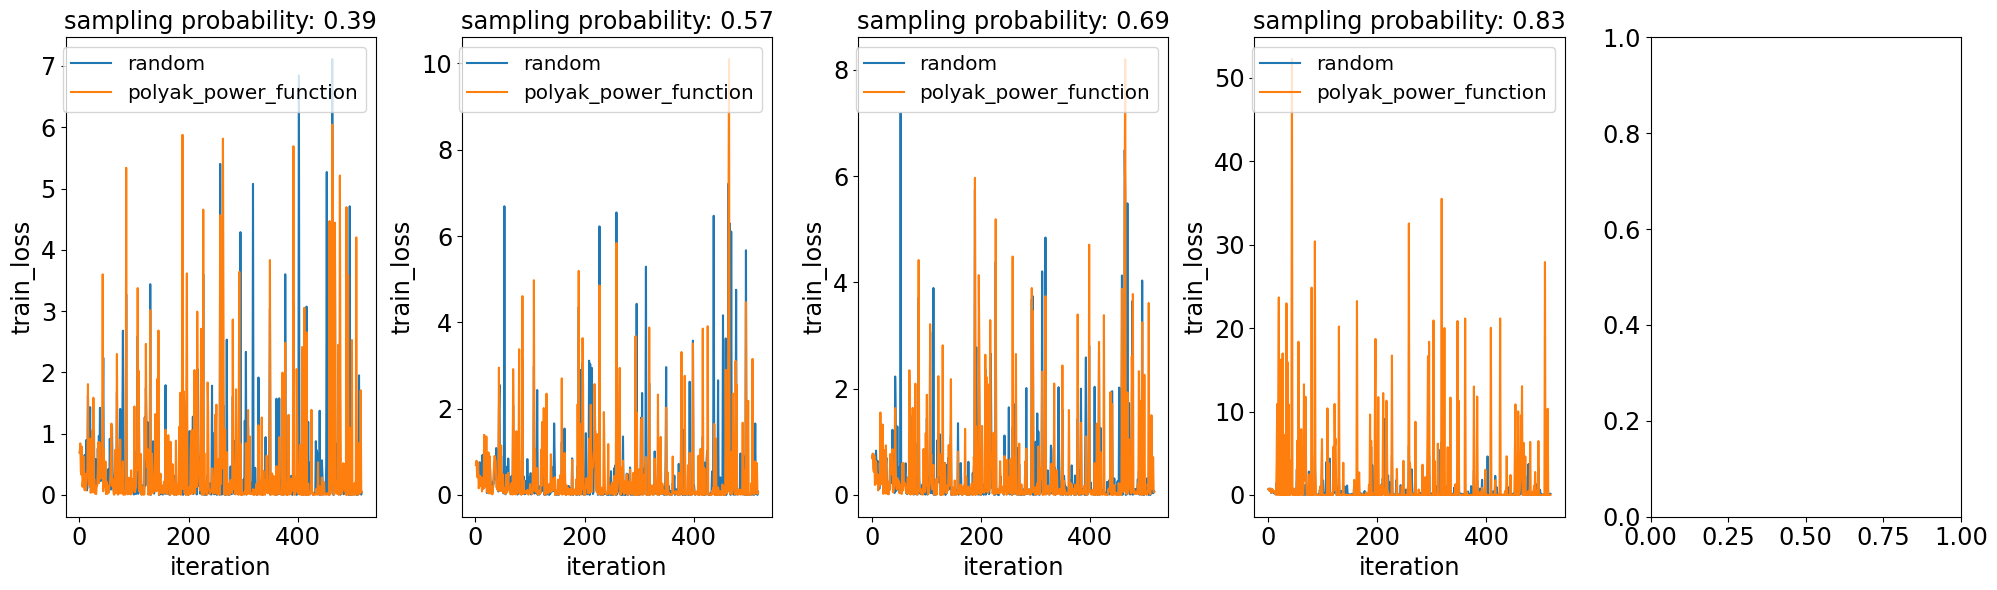

In [44]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="train_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    
    i+=1
f.tight_layout()

0.38860587305379374
Polyak exp value 73.9 has rows (1034, 16)
0.5690824703274531
Polyak exp value 36.9 has rows (1034, 16)
0.6889058695429708
Polyak exp value 22.2 has rows (1034, 16)
0.8336545964675897
Polyak exp value 11.1 has rows (1034, 16)


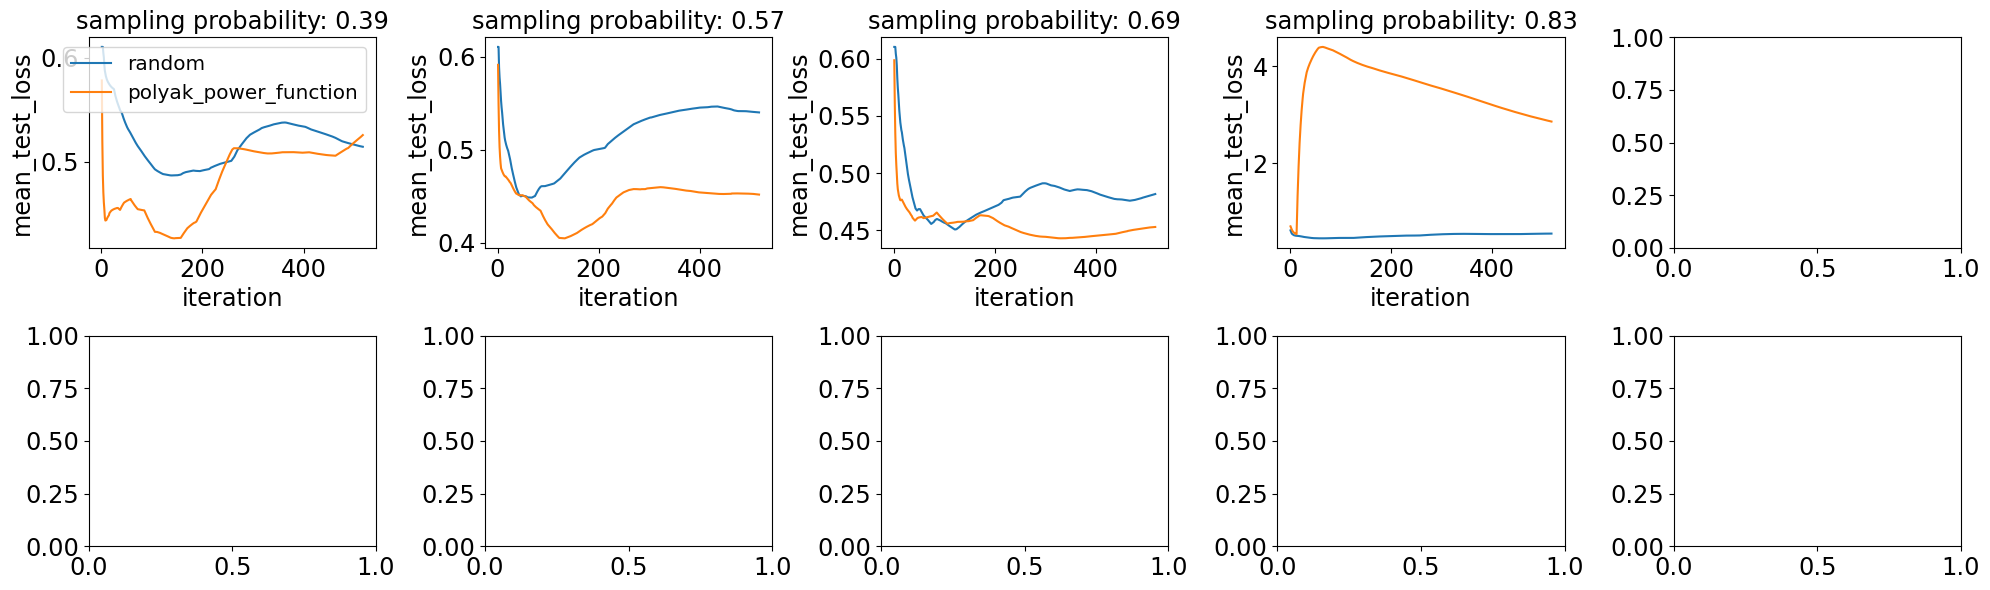

In [45]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
handles, labels = [], []

i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    if i == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    else:
        ax.get_legend().remove()
    
    i+=1
f.tight_layout()

# Plot 2: Polyak absloss vs absloss
First run absloss, then we run Polyak absloss with omega=1 with yields the same sampling probability

- mean train loss curve
- mean test loss curve
- accuracy

In [46]:
hyperparam_per_algo["polyak_absloss"]

{'kappa': 10, 'kappa0': 0.99, 'eta': 0.1, 'omega': 1.1}

In [47]:
results_polyak_random = train_model(
    X, y, Xtest, ytest, mode="polyak_random", verbose=True, 
    #**(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
    **hyperparam_per_algo["polyak_absloss"] | {"pz0": absloss_mean_sampling_prob, "kappa": 4}
)

Training with algorithm polyak_random: 517 iterations with d=46
loss: 0.587467055585151, train loss: 0.6931471805599453, ||theta||_1: 1.9769238724604556 acc: 0.5
loss: 0.5763800344367299, train loss: 0.5695059706231078, ||theta||_1: 2.990441138371222 acc: 1.0
loss: 0.5248267315088296, train loss: 0.1489961781138479, ||theta||_1: 3.980592699240623 acc: 1.0
loss: 0.5110689986843706, train loss: 0.017743137151681406, ||theta||_1: 4.908034582915839 acc: 1.0
loss: 0.5496394184214781, train loss: 0.21259619181453135, ||theta||_1: 5.926391256948648 acc: 1.0
loss: 0.6170102540402012, train loss: 0.20347593580164994, ||theta||_1: 6.83750658595366 acc: 1.0
loss: 0.6278875815073518, train loss: 0.22054550640145196, ||theta||_1: 7.650539906904822 acc: 1.0
loss: 0.55178420333875, train loss: 0.019962542584480367, ||theta||_1: 7.066312262650145 acc: 1.0
loss: 0.5178602420726413, train loss: 0.3242152881555447, ||theta||_1: 8.043011549570076 acc: 1.0
loss: 0.5178602420726413, train loss: 0.0464463852

In [48]:
results_polyak_absloss = train_model(
    X, y, Xtest, ytest, mode="polyak_absloss", verbose=True, 
    #**(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
    **hyperparam_per_algo["polyak_absloss"]
)

Training with algorithm polyak_absloss: 517 iterations with d=46
loss: 0.6931471805599454, train loss: 0.6931471805599453, ||theta||_1: 0.0 acc: 0.5
loss: 0.5084366835742573, train loss: 0.22029574865868032, ||theta||_1: 5.51213589807992 acc: 1.0
loss: 0.5518425015288931, train loss: 0.017752513181809683, ||theta||_1: 7.7233283265681365 acc: 1.0
loss: 0.5205231444564317, train loss: 0.01897802291445472, ||theta||_1: 8.478857159633742 acc: 1.0
loss: 0.5205231444564317, train loss: 0.04350158210374278, ||theta||_1: 8.478857159633742 acc: 1.0
loss: 0.5515131109652258, train loss: 0.013793567857606673, ||theta||_1: 8.874861069139255 acc: 1.0
loss: 0.5515131109652258, train loss: 0.5221523684465644, ||theta||_1: 8.874861069139255 acc: 1.0
loss: 0.5687520822284333, train loss: 0.1185412465310379, ||theta||_1: 8.72676590478886 acc: 1.0
loss: 0.51382134326642, train loss: 0.123193950264117, ||theta||_1: 9.148385645966776 acc: 1.0
loss: 0.440770384580167, train loss: 0.01532658451257852, ||thet

In [49]:
hppa = hyperparam_per_algo["polyak_absloss"]
hppa["omega"] *= np.mean(results_absloss["probs"]) / np.mean(results_polyak_absloss["probs"])
hyperparam_per_algo["polyak_absloss"] = hppa
print(hppa)

{'kappa': 10, 'kappa0': 0.99, 'eta': 0.1, 'omega': 1.2746946188493535}


In [50]:
plot2_df = results_to_df(
    {
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss,
    }
)

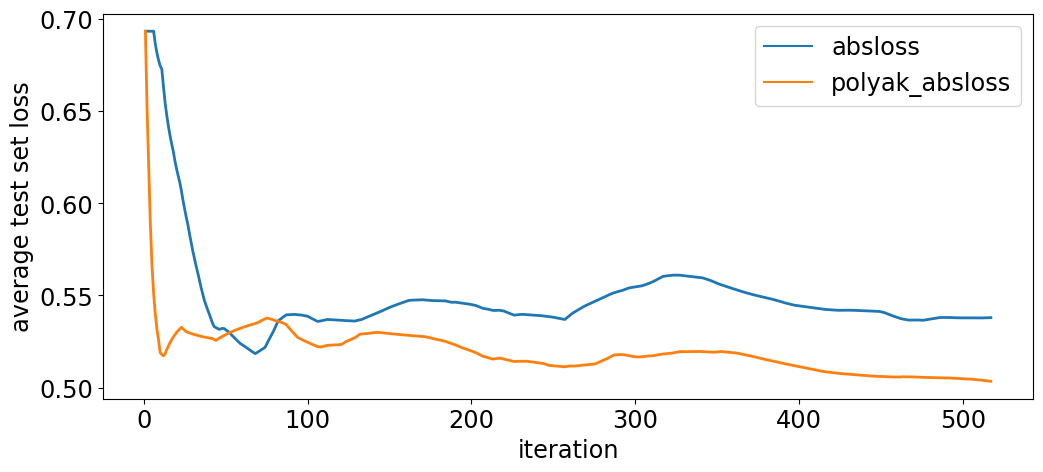

In [51]:
plt.figure(figsize=(12,5))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_loss",
    hue="method",
    linewidth=2
)

legend = ax.get_legend()
legend.set_title('')

ax.set(ylabel="average test set loss")

plt.savefig(f"figure_7b_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

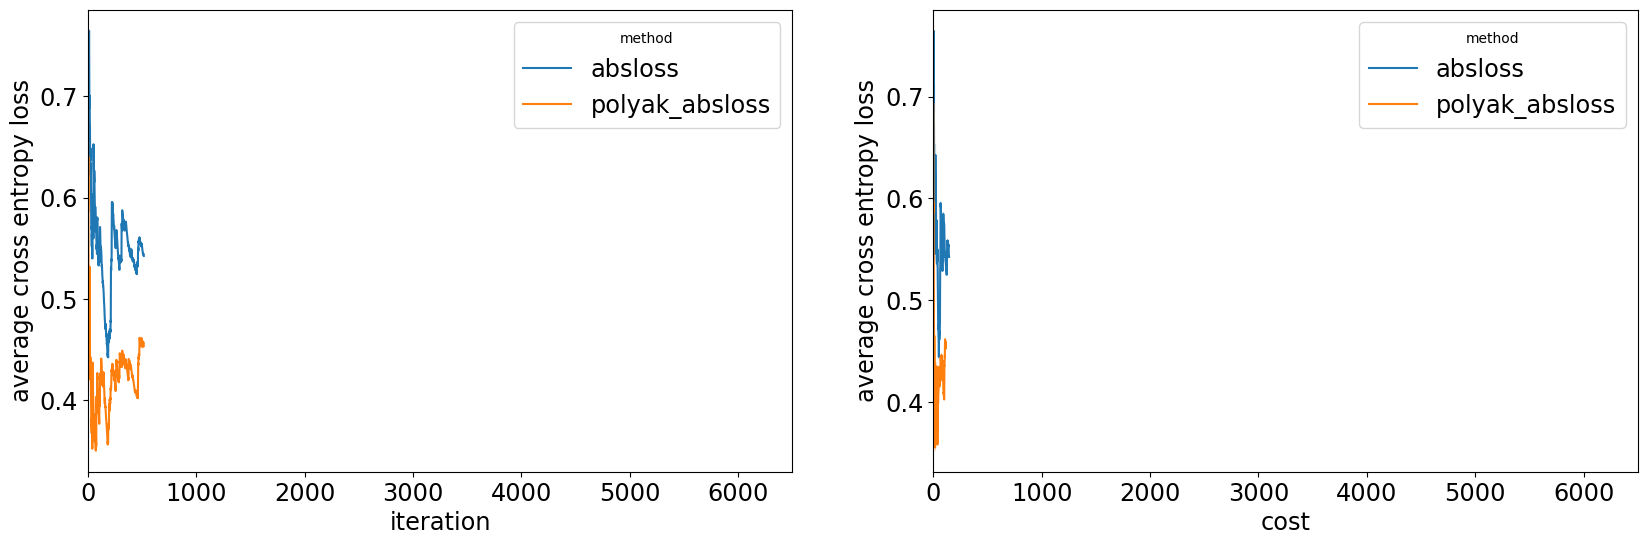

In [52]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot2_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")
    axs[i].set_xlim((0, 6499))

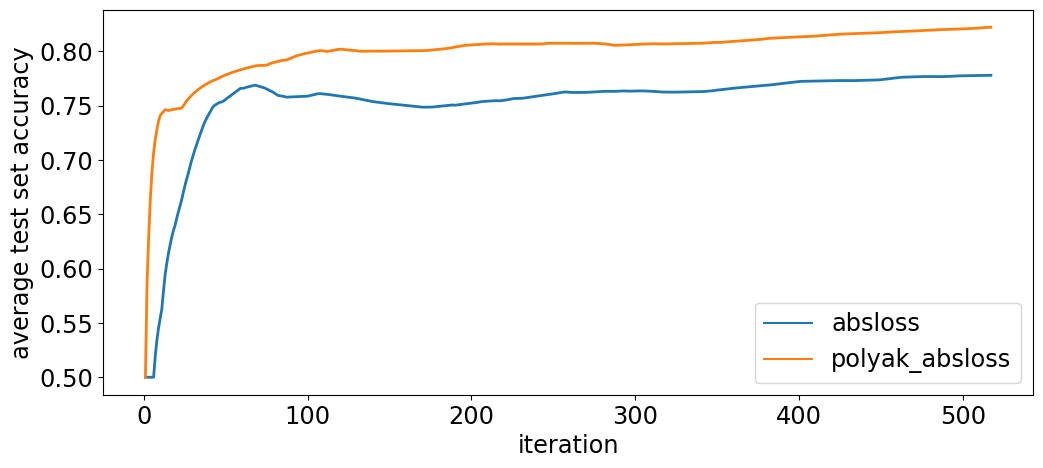

In [53]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_accuracy",
    hue="method",
    linewidth=2
)

ax.set(ylabel="average test set accuracy")

legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_8b_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

In [54]:
plot02_df = results_to_df(
    {
        "random": results_rand,
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss,
        "polyak_random": results_polyak_random
    }
)

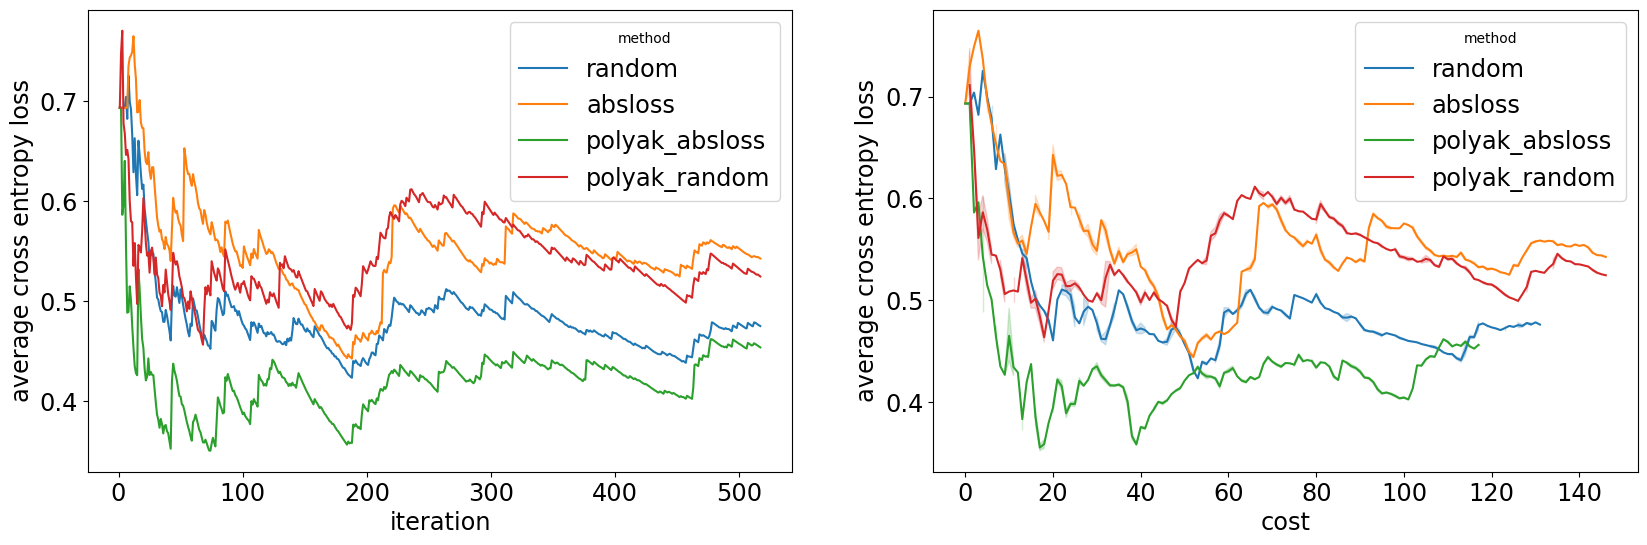

In [55]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")

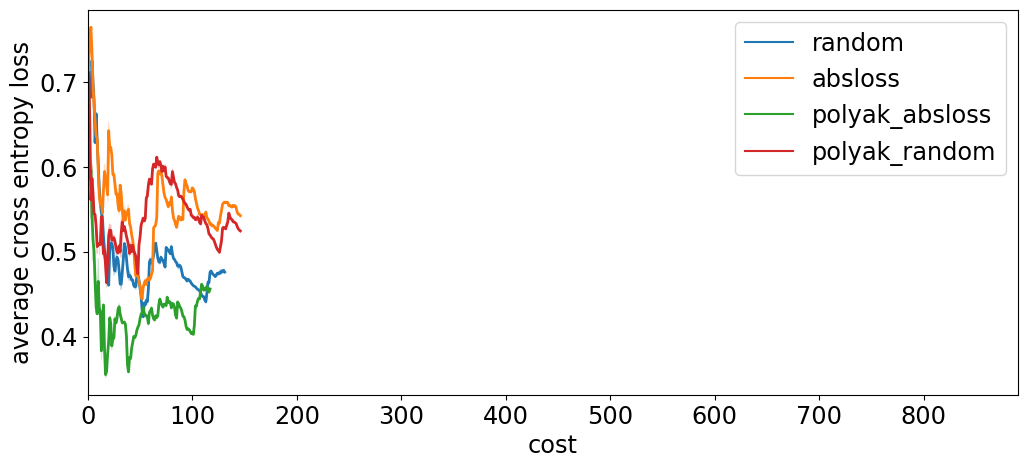

In [56]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12,5))

ax = sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    linewidth=2
)

ax.set(ylabel="average cross entropy loss")
ax.set_xlim((0, 890))

legend = ax.get_legend()
legend.set_title('')

plt.savefig(f"figure_6_icml_{dataset_name}.pdf", format="pdf", bbox_inches="tight")

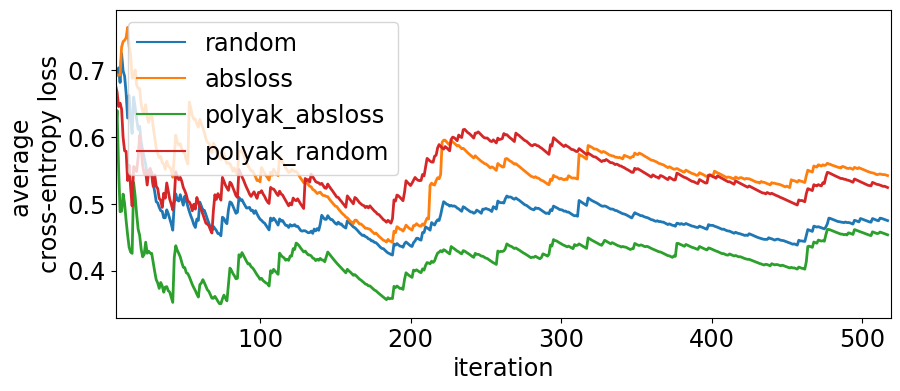

In [57]:
plt.figure(figsize=(10,4))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    linewidth=2
)
legend = ax.get_legend()
legend.set_title('')
ax.set_xlim((4, 519))

ax.set(ylabel="average \ncross-entropy loss")

plt.savefig(f"figure_3_icml_{dataset_name}_26.pdf", format="pdf", bbox_inches="tight")


In [58]:
2

2